#Adaptive Audio: Personalizing Sound Based on Your Hearing Profile

**by Dan Harvey**

dan [at] danielyusay.com  

daniel.harvey [at] columbia.edu




Humans typically hear frequencies between 20 Hz and 20,000 Hz, but this range changes over time. We don’t start life hearing the full spectrum—instead, our hearing develops through childhood and peaks in our teenage years. As we age, especially into adulthood, higher frequencies often degrade—a process known as age-related hearing loss.

This means the music you hear today might not sound the same to you as it did when it was mastered in the studio. Professional audio tracks are carefully engineered with frequency precision during the mastering process. However, what we actually perceive depends on many variables: digital-to-analog conversion, headphone distortion, encoding, codecs, bitrates, calibration mismatches, and importantlym our own unique hearing profiles.

##A Technical Intro

This project combines principles from audiometry, digital signal processing (DSP), and machine learning to build a personalized audio correction system. We begin by generating a frequency sweep (e.g. 20 Hz to 20 kHz) and analyzing user response to map out frequency-dependent hearing loss. This forms a personal hearing curve.

We then apply digital filters—such as parametric equalizers, FIR/IIR filters, or adaptive gain mapping—to reshape audio playback in real time or during preprocessing. Our goal is to approximate an inverse filter of the hearing loss curve, effectively restoring frequencies attenuated by hearing degradation.

To explore automation and personalization, we also investigate:

* ML regression models to predict optimal EQ profiles
* FFT-based feature extraction from audio and hearing profiles
* Potential use of neural audio compensation networks for end-to-end mapping.

##Project Goals
This mini research project explores:

* Characterizing individual hearing loss across frequencies
* Visualizing hearing drop-offs
* Compensating audio playback to restore missing frequencies
* Integrating basic ML approaches to personalize and automate correction

The goal is to create a small pipeline that adjusts music playback based on your actual hearing profile, potentially restoring what’s missing from your listening experience.

If this project interests you or you'd like to collaborate, feel free to email, leave a comment, or star the repo!

In [2]:
# Install required libraries

#You may need to pip these first
!pip install pytube pydub
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from IPython.display import Audio, display
from scipy.signal import spectrogram
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from pytube import YouTube
from pydub import AudioSegment
import os
import librosa
from scipy.signal import chirp
from scipy.fft import fft, fftfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.0 MB/s eta 0:00:00


## Understanding Audio: The Building Blocks

###First, let’s talk about what audio really is.

Sound is fundamentally made up of sine waves: smooth, periodic oscillations that occur at various frequencies. Every sound we hear, from a simple beep to a complex musical chord, can be broken down into a combination of these sine waves and their harmonics.

The Fourier Transform is a mind blowing almost seemingly impossible (quoting my Professor Carl Vondrick) powerful decomposition:  Sound (or frequency including light for that matter), no matter how complex—can be decomposed into a sum of sine waves at different frequencies and amplitudes. This principle is what allows us to analyze, process, and even recreate audio digitally.

Before diving into real-world audio, which is a blend of multiple frequencies, it's helpful to explore a basic sine wave. This gives us a sense of how a single frequency sounds and how it forms the foundation of everything we hear.

In [3]:
# Understanding Audio: The Building Blocks
# Generate a signal

# Let's sample a frequency
frequency = 30  # in Hz
duration = 1    # in seconds

# Bitrate or sample rate is how many samples we take per second.
# While we are not focusing on bitrate analysis right now,
# this sample rate is necessary to accurately recreate the waveform.
sample_rate = 44100  # samples per second (bitrate, disregarded for now)

# Create a time vector - a space where we can represent data over time
# Numpy's linspace divides a time segment into evenly spaced intervals
# Total samples = duration * sample_rate
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate sine wave signal
# Here we use the Numpy function to generate a sine wave over the time vector
# t is our time vector
# signal is our amplitude

signal = np.sin(2 * np.pi * frequency * t)

# Generate sine wave signals
signal_30hz = np.sin(2 * np.pi * 30 * t)
signal_60hz = np.sin(2 * np.pi * 60 * t)
signal_100hz = np.sin(2 * np.pi * 100 * t)
signal_1khz = np.sin(2 * np.pi * 1000 * t)

##Visualizing a Sine Wave: 30 Hz Example

The Hertz (Hz) is an SI unit of frequency that represents the number of cycles per second. So, a 30 Hz signal completes 30 full wave cycles every second.

If we were to observe a 30 Hz signal on an oscilloscope—a test instrument used to visualize voltage over time—we’d see a smooth, repeating wave that oscillates exactly 30 times across one second.

It would look like this:

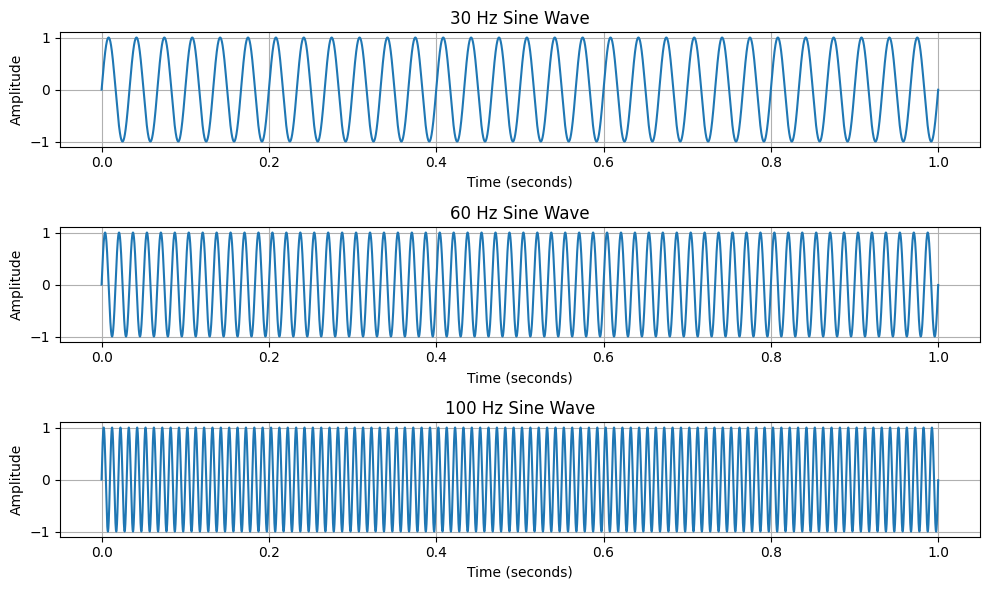

In [4]:
# Plot the signals for comparison
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t, signal_30hz)
plt.title("30 Hz Sine Wave")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, signal_60hz)
plt.title("60 Hz Sine Wave")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, signal_100hz)
plt.title("100 Hz Sine Wave")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

##Listening to a Sine Wave

This is sound, after all.

Low frequencies—like 20 to 100 Hz—are often felt more than heard, experienced as rumbles or deep vibrations. Think of the thump of a marching drum or an explosion during a movie in the theatres. This is what we commonly refer to as bass. As frequency increases, the sound becomes sharper and more piercing—high-pitched tones that form the treble range.

From 100 to 1000Hz it changes drastically - remember this is the same sine wave in amplitude just at a faster frequency.

To get a sense of how pure sine waves sound, press the play button below:

<sub>(Note: Audio playback only works in supported environments. I wrote this in Colab, so you can generate tones below.)</sub>

In [5]:
# Save each signal and play
frequencies = [(30, signal_30hz), (60, signal_60hz), (100, signal_100hz), (1000, signal_1khz)]
for freq, signal in frequencies:
    signal_pcm = np.int16(signal * 32767)
    wav_filename = f"{freq}Hz_sine.wav"
    write(wav_filename, sample_rate, signal_pcm)
    print(f"🔊 {freq} Hz sine wave. Play below:")
    display(Audio(wav_filename))

🔊 30 Hz sine wave. Play below:


🔊 60 Hz sine wave. Play below:


🔊 100 Hz sine wave. Play below:


🔊 1000 Hz sine wave. Play below:


### From Pure Tone to Real Sound: Spectrograms and FFT

Now that we have a sense of how a pure sine wave looks and sounds, it's important to realize that real-world audio is far messier. Instead of clean, single-frequency tones, most natural sounds are made up of many frequencies layered together and their reflections (also known as )—speech, music, noise—all are rich in complexity.

Before diving into experiments, let’s introduce two essential tools for visualizing this complexity:

### 📈 Spectrogram (or Spectrum Analyzer)
A spectrogram is a plot of frequency over time. You can think of it as a time-evolving version of an oscilloscope that shows how the frequency content of a signal changes as it progresses.

* X-axis: Time
* Y-axis: Frequency
* Color intensity: Amplitude or signal strength

This is commonly used in audio analysis, speech processing, and music production. It’s sometimes referred to as a spectrum analyzer when used in hardware form.

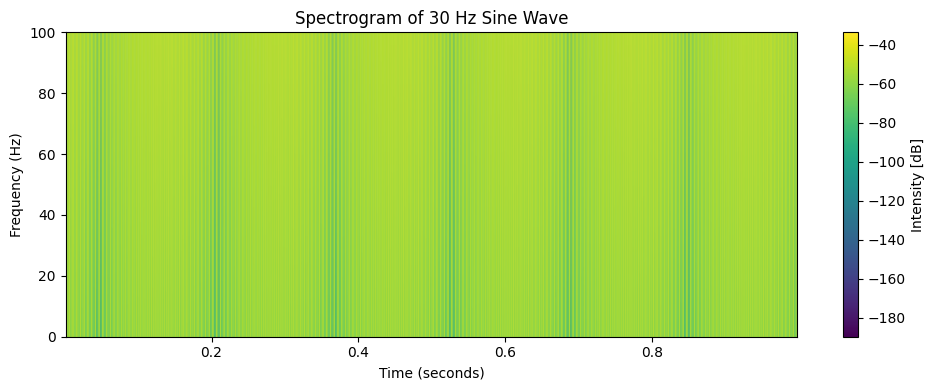

In [6]:
# --- Plot Spectrogram ---
f, time_spec, Sxx = spectrogram(signal_100hz, fs=sample_rate, nperseg=128)

plt.figure(figsize=(10, 4))
plt.pcolormesh(time_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylim([0, 100])  # Focus around the low frequency region
plt.title('Spectrogram of 30 Hz Sine Wave')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()
plt.show()

## ⚡️ Fast Fourier Transform (FFT)
A Fast Fourier Transform (FFT) is an algorithm that converts a signal from the time domain to the frequency domain.

A time-domain signal shows amplitude over time
An FFT shows frequency components over amplitude, revealing what frequencies are present in a given signal and how strong they are
This is especially useful for identifying dominant tones, noise components, and understanding the structure of sound.

For example, if you input a 1 kHz sine wave, the FFT will show a sharp peak at 1000 Hz, indicating the presence of that frequency.

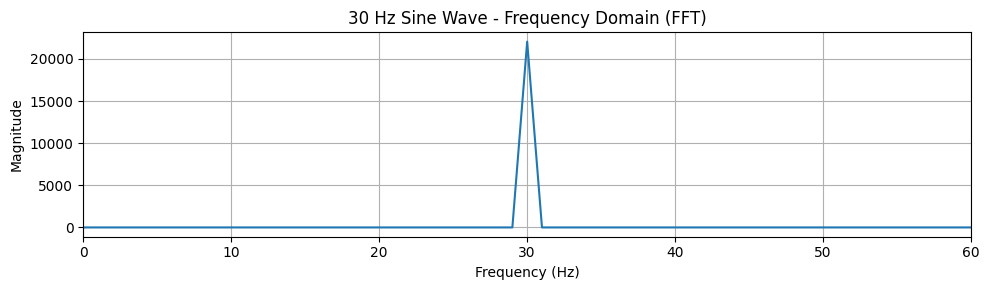

In [7]:
# Compute FFT
fft_result = np.fft.fft(signal_30hz)
fft_freqs = np.fft.fftfreq(len(fft_result), 1 / sample_rate)

# Keep positive frequencies only
pos_mask = fft_freqs >= 0
fft_magnitude = np.abs(fft_result)[pos_mask]
fft_freqs = fft_freqs[pos_mask]

# Plot Frequency-Domain
plt.figure(figsize=(10, 3))
plt.plot(fft_freqs, fft_magnitude)
plt.title("30 Hz Sine Wave - Frequency Domain (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.xlim(0, 60)  # Adjust this to change what Freqs are covered
plt.tight_layout()
plt.show()

### FFT on Real Audio

Now that we have our visual tools, lets take a look at the frequnecies present during this audio clip.

In [8]:
# Let's now analyze some real noise. We will visualize FFT on this audio
sample_track = '/content/noise.wav.m4a'

# Load audio using librosa (supports .m4a and resamples to target rate)
audio_data, sr = librosa.load(sample_track)

# Compute FFT
fft_result = np.fft.fft(audio_data)
fft_freqs = np.fft.fftfreq(len(fft_result), 1 / sample_rate)

# Keep positive frequencies only
pos_mask = fft_freqs >= 0
fft_magnitude = np.abs(fft_result)[pos_mask]
fft_freqs = fft_freqs[pos_mask]

# Plot Frequency-Domain
plt.figure(figsize=(10, 3))
plt.plot(fft_freqs, fft_magnitude)
plt.title("Real Noise Sample - Frequency Domain (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 20000)
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-8-24010a86cf04>:5: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(sample_track)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/noise.wav.m4a'

# 🎧 Part 2: Sweeping the Range of Human Hearing

Now let’s explore the range of frequencies that humans can typically hear—from deep bass to piercing treble.

Over the course of 10 seconds, we’ll generate and play a tone that sweeps from 10 Hz up to 20,000 Hz (20 kHz).
To better match how we perceive sound, we’ll sweep the frequencies in a logarithmic fashion because human hearing is not linear, we perceive differences in pitch more evenly across a logarithmic frequency scale. This makes the sweep feel smooth and natural, rather than rushed at the low end and stretched at the high end.

This type of sound is called a frequency sweep, and it’s widely used in hearing tests, speaker calibration, and audio diagnostics.

.

In [12]:
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio

# --- Parameters ---
sample_rate = 44100
duration = 5  # total duration in seconds
n_steps = 500  # number of discrete frequency steps in the sweep
freqs = np.logspace(np.log10(10), np.log10(20000), n_steps)

# Each frequency lasts for:
samples_per_step = int((sample_rate * duration) / n_steps)

# --- Generate sweep manually ---
sweep_signal = np.concatenate([
    np.sin(2 * np.pi * f * np.arange(samples_per_step) / sample_rate)
    for f in freqs
])

# Normalize
sweep_signal = sweep_signal / np.max(np.abs(sweep_signal))
sweep_signal_pcm = np.int16(sweep_signal * 32767)

# Save to WAV and play
write("manual_log_sweep.wav", sample_rate, sweep_signal_pcm)
Audio("manual_log_sweep.wav")

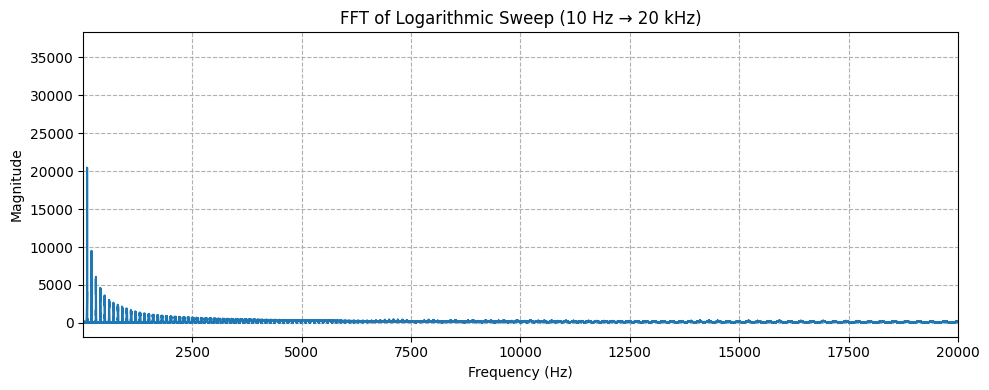

In [13]:
# --- Compute FFT ---
N = len(sweep_signal)
fft_result = fft(sweep_signal)
frequencies = fftfreq(N, d=1/sample_rate)

# Keep only positive frequencies
pos_mask = frequencies >= 0
fft_magnitude = np.abs(fft_result)[pos_mask]
fft_freqs = frequencies[pos_mask]

# --- Plot FFT ---
plt.figure(figsize=(10, 4))
plt.plot(fft_freqs, fft_magnitude)
plt.title("FFT of Logarithmic Sweep (10 Hz → 20 kHz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
#plt.xscale("log")
plt.xlim(10, 20000)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio

# --- Parameters ---
sample_rate = 44100
duration = 10  # seconds
frequency = 5000  # Hz (fixed)
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# --- Generate base tone ---
tone = np.sin(2 * np.pi * frequency * t)

# --- Create logarithmic volume ramp ---
# Log ramp from 0.001 (near silence) to 1.0 (full volume)
log_ramp = np.logspace(-5, 0, len(t))  # base 10 log scale
log_ramp /= np.max(log_ramp)  # normalize to 0 → 1

# Apply volume ramp
tone_log_ramped = tone * log_ramp

# --- Create chopped envelope (0.1 sec on/off cycle) ---
chop_duration = 0.1  # seconds
samples_per_chop = int(chop_duration * sample_rate)

on_ratio = 0.7
on_samples = int(samples_per_chop * on_ratio)
off_samples = samples_per_chop - on_samples

chop_pattern = np.concatenate([
    np.ones(on_samples),
    np.zeros(off_samples)
])

# Repeat to cover full signal
chop_mask = np.tile(chop_pattern, int(np.ceil(len(t) / len(chop_pattern))))
chop_mask = chop_mask[:len(t)]

# --- Final signal with log ramp and chops ---
final_signal = tone_log_ramped * chop_mask
final_signal /= np.max(np.abs(final_signal))  # normalize

# Convert to 16-bit PCM
signal_pcm = np.int16(final_signal * 32767)

# --- Save and play ---
write("1000Hz_log_volume_chop.wav", sample_rate, signal_pcm)
Audio("1000Hz_log_volume_chop.wav")


In [14]:
import numpy as np
import time
from scipy.io.wavfile import write
from IPython.display import Audio, display, clear_output
import ipywidgets as widgets

# --- Step 1: Generate the tone (1000Hz, log volume, chopped) ---
sample_rate = 44100
duration = 10  # seconds
frequency = 1000

t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
tone = np.sin(2 * np.pi * frequency * t)

log_ramp = np.logspace(-3, 0, len(t))
log_ramp /= np.max(log_ramp)

# Create 0.1s chopped envelope
chop_duration = 0.1
samples_per_chop = int(chop_duration * sample_rate)
on_ratio = 0.7
on_samples = int(samples_per_chop * on_ratio)
off_samples = samples_per_chop - on_samples
chop_pattern = np.concatenate([np.ones(on_samples), np.zeros(off_samples)])
chop_mask = np.tile(chop_pattern, int(np.ceil(len(t) / len(chop_pattern))))[:len(t)]

final_signal = tone * log_ramp * chop_mask
final_signal /= np.max(np.abs(final_signal))
signal_pcm = np.int16(final_signal * 32767)
write("log_volume_chopped.wav", sample_rate, signal_pcm)

# --- Step 2: UI for test ---
start_button = widgets.Button(description='Start Listening Test', icon='play')
heard_button = widgets.Button(description="I Heard It!", icon='check', button_style='success')
output = widgets.Output()

tone_start_time = None

def on_start_clicked(b):
    global tone_start_time
    with output:
        clear_output()
        print("Waiting 1 second...")
        time.sleep(1)
        print("Playing tone. Click when you hear it.")
        display(Audio("log_volume_chopped.wav", autoplay=True))
        tone_start_time = time.time()
        display(heard_button)

def on_heard_clicked(b):
    if tone_start_time is not None:
        elapsed = time.time() - tone_start_time
        with output:
            print(f"\n⏱️ You clicked after {elapsed:.2f} seconds of playback.")

start_button.on_click(on_start_clicked)
heard_button.on_click(on_heard_clicked)

display(start_button, output)



Button(description='Start Listening Test', icon='play', style=ButtonStyle())

Output()